In [1]:
import torch
# 하이퍼파라미터
EPOCH = 5
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [2]:
from torchvision import transforms, datasets
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    root = 'c:/data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

100%|██████████| 26421880/26421880 [00:09<00:00, 2915753.75it/s]


Extracting c:/data/FashionMNIST\raw\train-images-idx3-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 102530.64it/s]


Extracting c:/data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1604172.11it/s]


Extracting c:/data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to c:/data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting c:/data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to c:/data/FashionMNIST\raw



In [3]:
from torch import nn, optim
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #784 => 3차원 압축
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        # 3=> 784 복원
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [5]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
view_data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [6]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


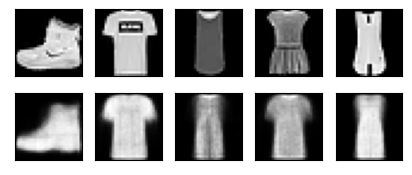

[Epoch 2]


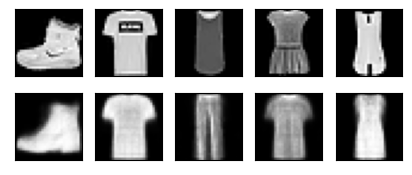

[Epoch 3]


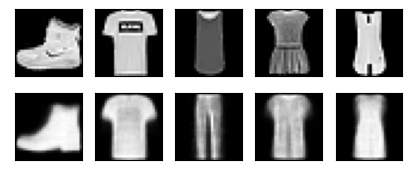

[Epoch 4]


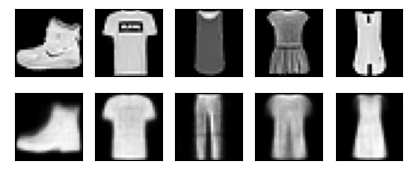

[Epoch 5]


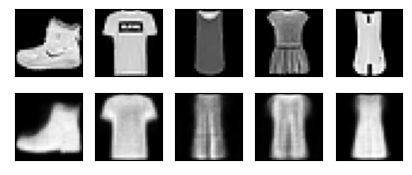

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)
    # 복원 이미지
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)
    f, a = plt.subplots(2, 5, figsize=(5, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28, 28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

In [8]:
view_data = trainset.data[:200].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")
encoded_data.shape

torch.Size([200, 3])

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_556\835069715.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


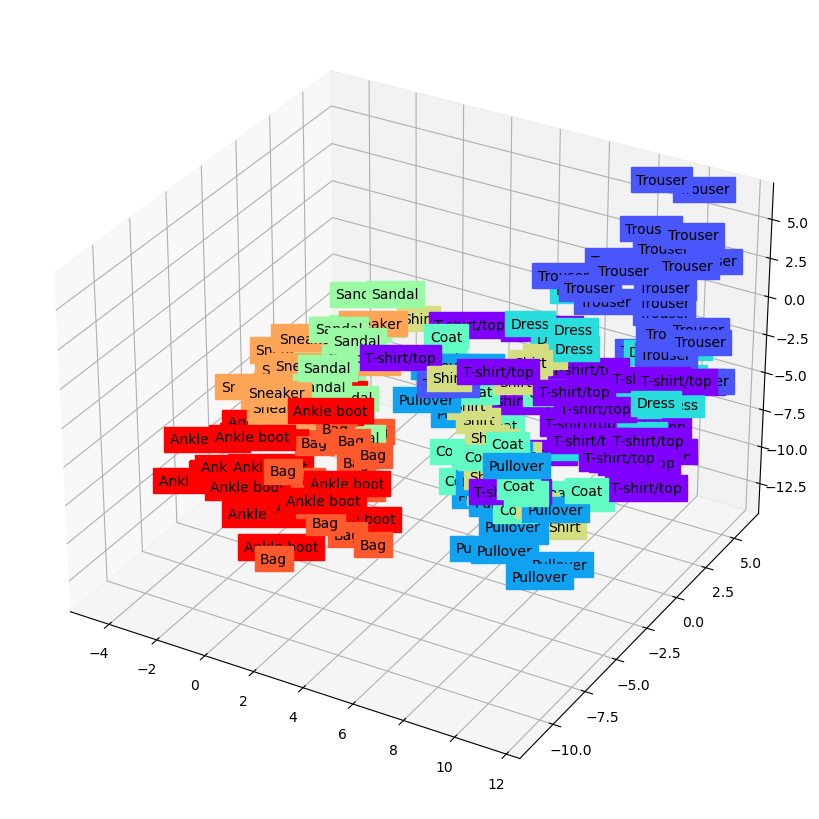

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()
labels = trainset.targets[:200].numpy()
for x, y, z, s in zip(X, Y, Z, labels):
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x, y, z, name, backgroundcolor=color)
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()